# Pneumothorax demo

This demo exists to show some additional functionality of misas and to demonstrate that it is applicable to non MRI data. In this case chest X-rays.
This demo is a variation of the one shown in the fastai 2 docs where the dataset is used for classification. We use it to do segmentation.

> Warning:
We will massively overfit the data just to showcase some functionality. The resulting model is not suitable for productive usage at all.

In [ ]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

In [ ]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from fastai.vision.all import *
from fastai.medical.imaging import *
import torchvision
import torchvision.transforms as t

In [ ]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

In [ ]:
pneumothorax_source.ls()

(#2) [Path('/tmp/fastai/siim_small/train'),Path('/tmp/fastai/siim_small/labels.csv')]

In [ ]:
items = get_dicom_files(pneumothorax_source/f"train/")

In [ ]:
df = pd.read_csv(pneumothorax_source/f"labels.csv")
df.head()

,file,label
0,train/No Pneumothorax/000000.dcm,No Pneumothorax
1,train/Pneumothorax/000001.dcm,Pneumothorax
2,train/No Pneumothorax/000002.dcm,No Pneumothorax
3,train/Pneumothorax/000003.dcm,Pneumothorax
4,train/Pneumothorax/000004.dcm,Pneumothorax


In [ ]:
df_pneumo = df[df['label']=='Pneumothorax']

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILDicom), MaskBlock(codes=['bg','pneumo'])),
                   get_x=lambda x:pneumothorax_source/f"{x[0]}",
                   get_y=lambda x:'example/siim/'+Path(x[0]).stem+'.png',
                   batch_tfms=aug_transforms(do_flip=False,p_affine=0,p_lighting=0,size=224))

dls = pneumothorax.dataloaders(df_pneumo.values, num_workers=0, bs=16)

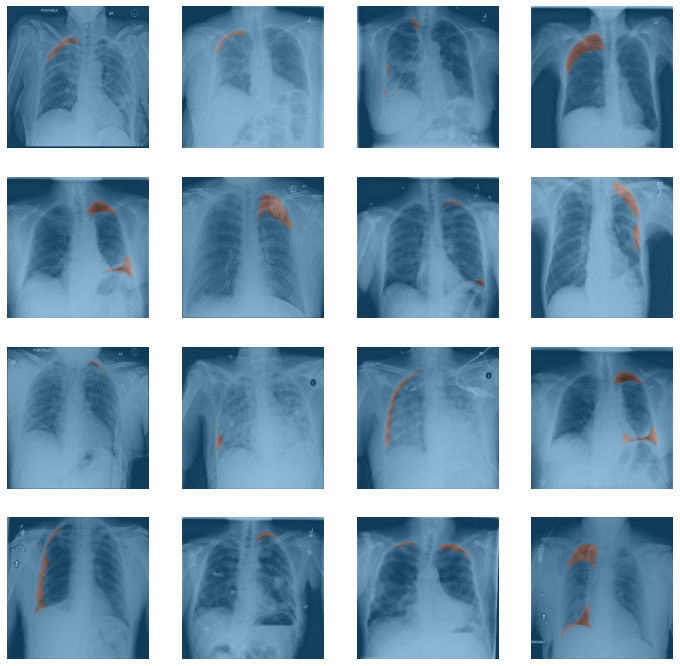

In [ ]:
dls.show_batch(max_n=16, vmin=0)

In [ ]:
# just for testing - you can skip this when running interactively
learn = unet_learner(dls, resnet34)


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


In [ ]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,time
0,0.973538,0.237179,18:50


epoch,train_loss,valid_loss,time
0,0.160098,0.077130,03:26


In [ ]:
#slow
# this is skipped when testing, instead a single epoch is done (not sufficient for overfitting)
learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,0.337435,0.096693,01:16


epoch,train_loss,valid_loss,time
0,0.147249,0.081404,01:21
1,0.116825,0.070488,01:25
2,0.119346,0.083596,01:29
3,0.112306,0.066642,01:17
4,0.103079,0.086541,01:24
5,0.097445,0.064313,01:16
6,0.091854,0.069251,07:04
7,0.087729,0.065811,01:14


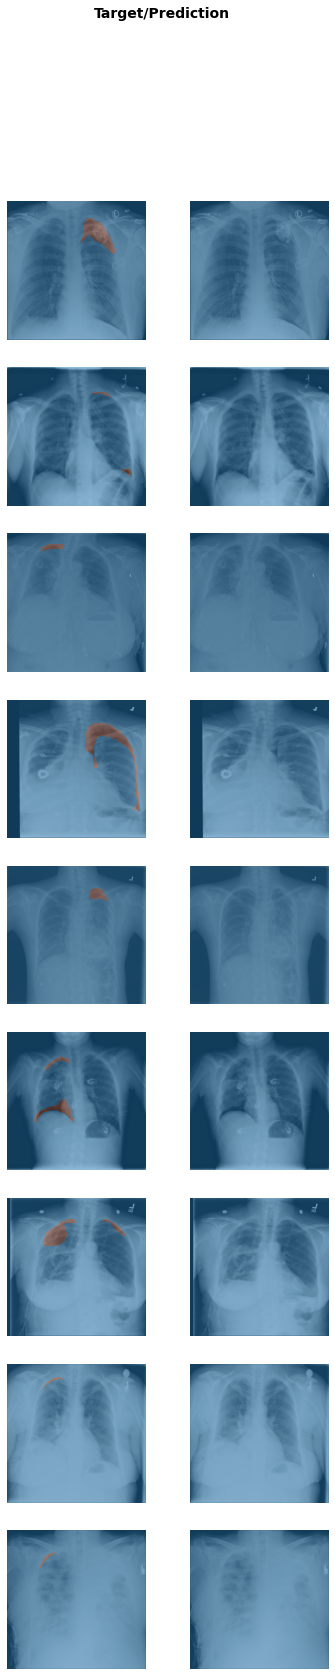

In [ ]:
learn.show_results(ds_idx=0,max_n=9,vmin=0)

In [ ]:
preds = learn.get_preds(ds_idx=0)

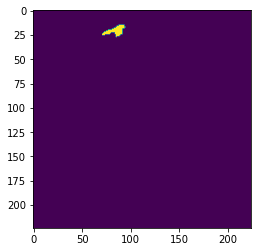

In [ ]:
plt.imshow(preds[1][2])

In [ ]:
preds[0].argmax(dim=1).sum()
#plt.imshow(preds[0].argmax(dim=1)[0])

TensorBase(0)

In [ ]:
#slow
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,0.074251,0.243393,00:56


epoch,train_loss,valid_loss,time
0,0.133681,0.077082,00:58
1,0.114310,0.058616,01:00
2,0.101132,0.094836,01:00
3,0.094086,0.052810,01:15
4,0.090113,0.052121,01:01
5,0.082591,0.110594,01:01
6,0.080298,0.088948,01:31
7,0.076252,0.076792,01:24


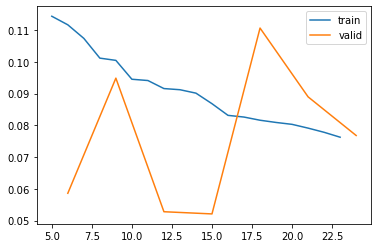

In [ ]:
learn.recorder.plot_loss()

In [ ]:
preds = learn.get_preds(ds_idx=0)
preds[0].argmax(dim=1).sum()

TensorBase(0)

TensorBase(0.2282)
TensorBase(0.2712)
TensorBase(0.1552)
TensorBase(0.1953)
TensorBase(0.2204)


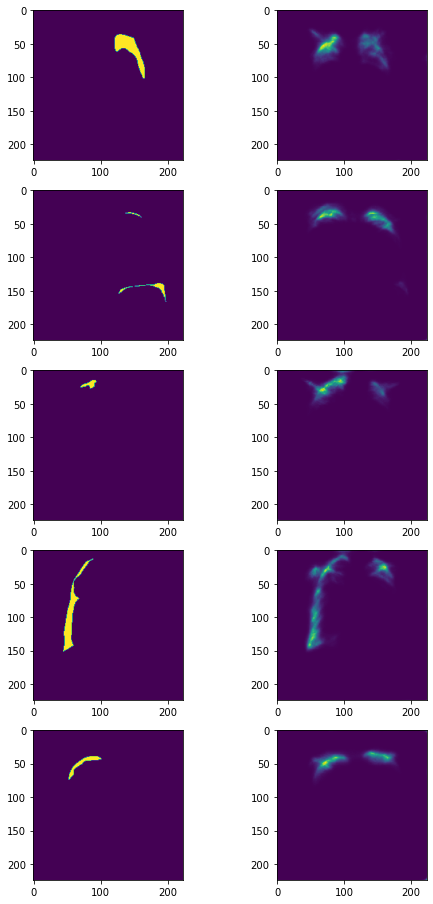

In [ ]:
fig, axs = plt.subplots(5,2,figsize=(8,16))
for i in range(5):
    axs[i,0].imshow(preds[1][i])
    axs[i,1].imshow(preds[0][i][1])
    print(preds[0][i][1].max())

In [ ]:
#slow
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,time
0,0.050908,0.050838,01:03
1,0.053009,0.394894,00:57
2,0.066356,0.258493,01:25
3,0.069475,0.065642,01:04
4,0.065846,0.057882,00:58
5,0.063218,0.052748,01:01
6,0.060191,0.053164,00:59
7,0.058425,0.052076,00:58


In [ ]:
preds = learn.get_preds(ds_idx=0)
preds[0].argmax(dim=1).sum()

TensorBase(0)

In [ ]:
#slow
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,time
0,0.045841,0.050845,01:01
1,0.046395,0.053681,01:01
2,0.044307,0.067818,01:00
3,0.042078,0.077163,00:57
4,0.039723,0.060332,00:58
5,0.037444,0.072099,01:01
6,0.035674,0.048563,00:56
7,0.034659,0.049017,00:57
8,0.033289,0.082797,01:00
9,0.031744,0.069918,01:33


In [ ]:
preds = learn.get_preds(ds_idx=0)
preds[0].argmax(dim=1).sum()

TensorBase(49530)

TensorBase(0.9930)
TensorBase(0.9893)
TensorBase(0.9797)
TensorBase(0.9714)
TensorBase(0.9671)


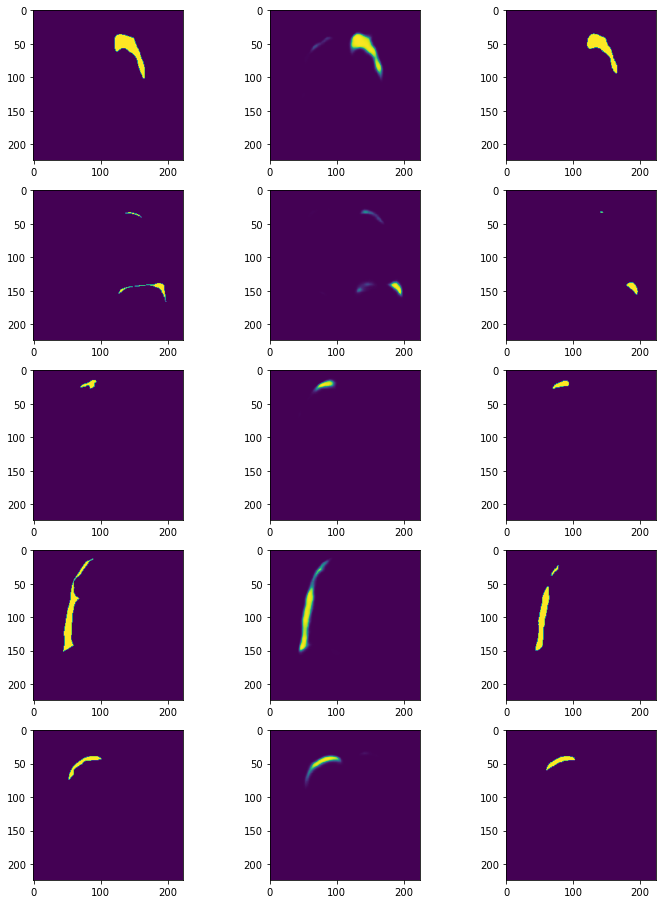

In [ ]:
fig, axs = plt.subplots(5,3,figsize=(12,16))
for i in range(5):
    axs[i,0].imshow(preds[1][i])
    axs[i,1].imshow(preds[0][i][1])
    axs[i,2].imshow(preds[0].argmax(dim=1)[i])
    print(preds[0][i][1].max())

In [ ]:
learn.save('pneumothorx')#learn.export(os.path.abspath('./my_export.pkl'))

Path('models/pneumothorx.pth')

### We managed to overfit

In [ ]:
learn.load ('pneumothorx')

In [ ]:
from misas.core import *
from fastai.vision.all import * #open_mask, Image, ImageSegment
import pydicom

In [ ]:
def read_dcm(file):
    ds = pydicom.dcmread(file)
    img = Tensor(ds.pixel_array.astype(np.int16))
    img = img/img.max()
    transform = t.ToPILImage()
    img = transform (torch.stack([img, img, img]))
    return img
    

<AxesSubplot:>

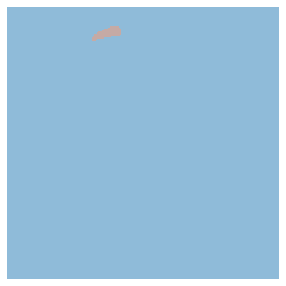

In [ ]:
learn.predict(learn.dls.train_ds.items[1])[0].show(vmin=0)

In [ ]:
fname = df_pneumo.iloc[3]['file']
img = lambda: read_dcm(pneumothorax_source/fname)
trueMask = lambda: Image.open('example/siim/'+Path(fname).stem+'.png') #open_mask('example/siim/'+Path(fname).stem+'.png')

In [ ]:
dcm = img()

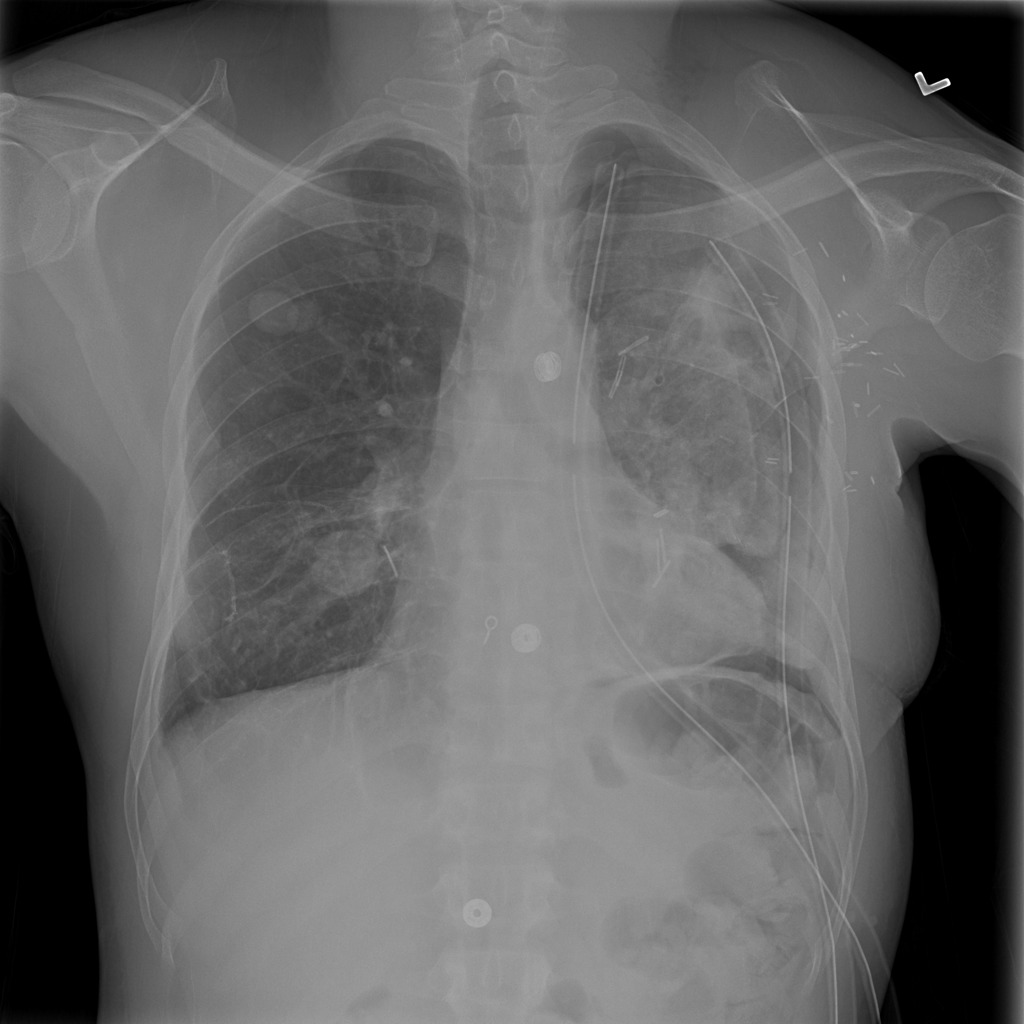

In [ ]:
dcm
#to_image(dcm.data)

<class 'fastai.torch_core.TensorBase'>
torch.Size([224, 224])


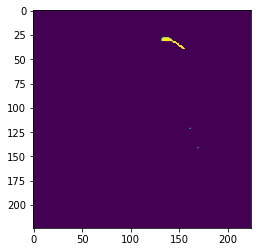

In [ ]:
pred = learn.predict(PILDicom(dcm))[1] #plt.imshow(learn.predict(PILDicom(dcm))[1]) #plt.imshow(learn.predict(PILDicom(to_image(dcm.data)))[1])
print(type(pred))
print(pred.shape)
plt.imshow(pred)


In [ ]:
class Fastai2_wrapper:
    def __init__(self, model):
        self.model = model
        self.model.cbs = L([])
    
    def imageToPILDicom(self, image):
        return PILDicom(image)
    
    def prepareSize(self, imageOrMask):
        return imageOrMask.resize((224,224))
    
    def predict(self, image):
        image = self.imageToPILDicom(image)
        pred = self.model.predict(image)[0]#(in_image)
        return Image.fromarray(np.array(pred).astype(np.uint8))

In [ ]:
model = Fastai2_wrapper(learn)

In [ ]:
#learn.cbs = L(learn.cbs)#
#learn.cbs.sorted()

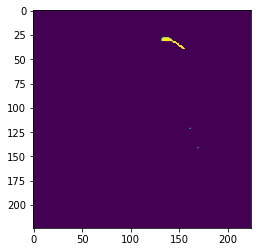

In [ ]:
plt.imshow(model.predict(img()))

  0%|          | 0/6 [00:00<?, ?it/s]

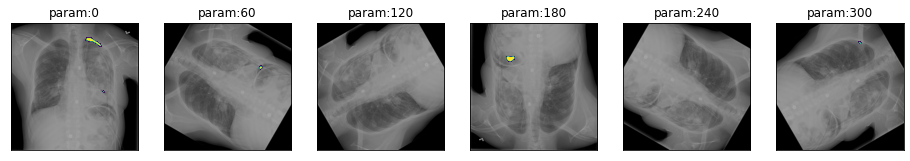

In [ ]:
plot_series(get_rotation_series(img(), model))

In [ ]:
result = eval_rotation_series(img(), trueMask(), model, start=-180, end=180, components=['bg','pneumo'])

  0%|          | 0/72 [00:00<?, ?it/s]

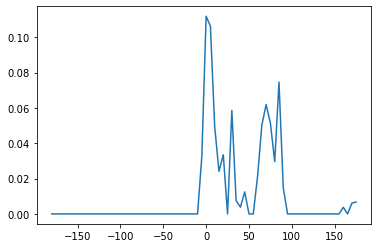

In [ ]:
plt.plot(result['deg'],result['pneumo'])

In [ ]:
#learn.cbs
#L([1,2,5,3]).sorted()
#L(learn.cbs).sorted()
#learn.cbs = L(learn.cbs)

In [ ]:
#learn.cbs.sorted()